### 주택 가격 예측 (House Price Regression)

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

# 경고문 미표시
import warnings
warnings.filterwarnings(action='ignore')

# 데이터프레임 표시 제한 설정
pd.options.display.max_rows = 30
pd.options.display.max_columns = 30

### 데이터 불러오기

In [2]:
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)

housing.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 데이터 상위 행 살펴보기

In [3]:
data = housing['frame']
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# OverallQual, GrLivArea, GarageCars 변수 선택
features = ['OverallQual', 'GrLivArea', 'GarageCars']
target = 'SalePrice'

X = data[features]
y = data[target]

In [5]:
X = data.select_dtypes(include=['number'])
X = X.drop(['Id', 'SalePrice'], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,...,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,...,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,...,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,...,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,...,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [6]:
# 결측치 처리
X = X.fillna(X.mean()) # 평균값으로 결측치 대체
X.isnull().sum().sort_values(ascending=False)

MSSubClass     0
LotFrontage    0
LotArea        0
OverallQual    0
OverallCond    0
              ..
ScreenPorch    0
PoolArea       0
MiscVal        0
MoSold         0
YrSold         0
Length: 36, dtype: int64

In [7]:
# Train - Test 분할 (Hold-out Validation)
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=X['OverallQual'], random_state=42)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(1168, 36) (1168,)
(292, 36) (292,)


### 확률적 경사하강법

### SGDRegressor

- SGDRegressor 알고리즘 : 경사하강법을 사용하여 최적의 가중치과 절편을 찾아낸다.

1. 임의의 가중치 w 와 절편 b 를 설정한다.

2. 현재 가중치와 절편을 사용해 예측값 y 를 계산한다.

3. 손실 함수를 사용하여 예측값과 실제값 간의 오차를 계산한다.

4. 손실 함수의 기울기(gradient) 를 계산하여 가중치를 업데이트한다.

5. 학습률(learning rate, eta0 : 초기 학습률) 을 사용하여 업데이트 크기를 조정한다.

6. 모델에서 설정한 max_iter(최대 반복 횟수) 또는 tol(조기 종료 조건)에 도달할 때까지 반복한다.

- LinearRegression 과 SGDRegressor 의 차이

| 특성           | LinearRegression      | SGDRegressor        |
|----------------|-----------------------|---------------------|
| 학습 방식      | 정규 방정식 (직접 해를 계산, 모든 데이터를 메모리에 올려놓고 연산)           | 경사하강법 (가중치 점진적 업데이트, 데이터 학습 배치 단위)         |
| 데이터 크기    | 작은 데이터셋에 적합  | 큰 데이터셋에 적합  |
| 속도           | 작은 데이터에서 빠름  | 큰 데이터에서 효율적 |
| 온라인 학습    | 불가능 (데이터 추가시 처음부터 학습)                | 가능 (새로운 데이터에 대해 추가 학습 가능)                |
| 정확성         | 정확한 해 계산        | 근사 해 (반복에 따라 달라짐) |
| 하이퍼파라미터 | 거의 없음             | 조정 가능 (학습률, 반복 등) |

- SGDRegressor 하이퍼파라미터

    - loss : 손실 함수

    - eta0 : 학습률

    - max_iter : 최대 반복 횟수

    - tol : 조기 종료 조건

    - penalty : 규제 (L1, L2, ElasticNet) 적용

- SGDRegressor 피처 스케일링

1. 각 피처의 값 범위가 다를 경우 경사하강법이 특정 피처에 더 민감하게 반응하거나, 무시하게 되는 문제가 발생하여 성능이 저하될 수 있다.

2. (위 코드의 경우) StandardScaler 를 통해 평균 0, 분산 1 인 데이터로 표준화하여 모든 피처가 동일한 스케일을 가져 모델이 편향되지 않는다.

3. SGDRegressor 외에도 LogisticRegression, SVM, K-Means 등 스케일에 민감한 알고리즘에서 필수적이다.

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

sgd_model = SGDRegressor(
    loss='squared_error',     # 손실함수
    eta0=0.01,                # 초기 학습률
    max_iter=10000,           # 반복 횟수
    tol=1e-3                  # 조기 종료 조건
)

sgd_model.fit(X_tr_scaled, y_tr)

# 성능 평가 (R^2 결정계수)
print(f"훈련 셋: {sgd_model.score(X_tr_scaled, y_tr)}")
print(f"검증 셋: {sgd_model.score(X_val_scaled, y_val)}")

훈련 셋: 0.8323516403573544
검증 셋: 0.7312606961302406


In [9]:
# 성능 평가 (MSE)
from sklearn.metrics import mean_squared_error
print(f"훈련 셋: {mean_squared_error(y_tr, sgd_model.predict(X_tr_scaled))}")
print(f"검증 셋: {mean_squared_error(y_val, sgd_model.predict(X_val_scaled))}")

훈련 셋: 962981123.7507414
검증 셋: 2297546109.1431246


In [10]:
# 성능 평가 (MAE)
from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_tr, sgd_model.predict(X_tr_scaled))}")
print(f"검증 셋: {mean_absolute_error(y_val, sgd_model.predict(X_val_scaled))}")

훈련 셋: 20616.262554610083
검증 셋: 25696.930921711148


### 비선형 회귀 분석

In [11]:
# data에서 수치형 변수만 선택 (과대적합 데이터)
X = data.select_dtypes(include=['number'])
X = X.drop(['Id', 'SalePrice'], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,...,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,...,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,...,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,...,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,...,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [12]:
# 결측치 처리
X = X.fillna(X.mean())
X.isnull().sum().sort_values(ascending=False)

MSSubClass     0
LotFrontage    0
LotArea        0
OverallQual    0
OverallCond    0
              ..
ScreenPorch    0
PoolArea       0
MiscVal        0
MoSold         0
YrSold         0
Length: 36, dtype: int64

### KNN (K-Nearest Neighbors)

- KNeighborsRegressor 알고리즘

1. 새 데이터 포인트에 대해 모든 데이터 포인트와의 거리를 계산한다.

2. 가장 가까운 N 개의 데이터 포인트를 선택한다. (파라미터 n_neighbors= 으로 설정)

3. N 개의 데이터의 평균값을 반환하여 에측값으로 사용한다.

- KNeighborsRegressor 하이퍼파라미터

    - n_neighbors : 가장 가까운 이웃의 수를 설정, 작으면 과대적합 크면 과소적합 가능성이 증가한다. (Default : 5)

    - weights : 각 이웃의 가중치를 설정한다. (Default : uniform)

        - uniform : 모든 이웃에 동일한 가중치를 부여

        - distance : 가까운 이웃에 더 큰 가중치를 부여

        - 그 외 사용자 정의 함수도 가능

    - metric : 거리 계산 방식을 설정한다. (Default : minokowski)

        - euclidean : 유클리드 거리

        - manhattan : 맨해튼 거리

        - minokowski : 일반화된 거리 척도도

- KNeighborsRegressor 의 특징

1. 모든 데이터와의 거리를 계산하기 때문에, 데이터가 많아질수록 계산 비용이 크게 증가한다. (작은 데이터셋에 적합)

2. 거리를 기반으로 하여 데이터가 표준화되지 않으면 특정 피처가 결과에 과도한 영향을 끼칠 수 있다. (Feature Scaling 필수)

3. 평균값을 사용하기 때문에 이상치 (outlier) 에 취약하다.

- KNeighborsRegressor 의 한계 보완

1. 가중치 적용 (weights='distance')

2. n_neighbors 값 조정

3. 이상치 처리

4. 그외 비선형 모델 사용 : 랜덤포레스트, SVM, 신경망

In [13]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4) # n_neighbors 값을 조절하는 것이 중요하다.
knn.fit(X_tr, y_tr)

print(f"훈련 셋: {knn.score(X_tr, y_tr)}")
print(f"검증 셋: {knn.score(X_val, y_val)}")

훈련 셋: 0.8023635449962838
검증 셋: 0.5822933982822356


In [14]:
# 성능 평가 (MSE)
print(f"훈련 셋: {mean_squared_error(y_tr, knn.predict(X_tr))}")
print(f"검증 셋: {mean_squared_error(y_val, knn.predict(X_val))}")

훈련 셋: 1135234343.7136664
검증 셋: 3571119533.7662673


### SVM (Support Vector Machine)

https://exem.tistory.com/1784

- SVM (Support Vector Machine) 알고리즘

    - SVC (Support Vector Classifier)

    1. 샘플 사이에 선을 그어 그 선의 폭이 최대가 되도록 샘플을 구분한다. 샘플이 n 개의 특성으로 표현된다면, 샘플들은 n 차원 데이터 공간에 분포한다. (아래 그림에서 b11 과 b12 의 차이, 즉 margin (마진)이라 한다. 구분해주는 선은 초평면이라 한다.)

    2. 선형 SVM 은 샘플 분할 경계가 복잡할 경우 분류 성능이 떨어진다. 이에 따라 kernel 이라는 매핑 함수를 통해 비선형 분할선을 정의하여 이를 해결한다.

    - SVR (Support Vector Regression)

    1. 두 클래스 간의 도로 폭(margin) 을 최대로 하고자 하는 분류와 반대로, 도로 안에 가능한 한 많은 샘플이 들어가도록 학습한다. 도로의 폭은 하이퍼파라미터 입실론(epsilon) 으로 조절한다.

- Hard Margin vs Soft Margin

    - 모든 샘플이 도로 바깥쪽에 올바르게 분류되어 있다면 하드 마진 분류라고 한다.

    - 선형적으로 구분 될 수 있어야 제대로 작동하고 이상치가 있다면 하드 마진을 찾을 수 없을 수도 있다.

    - 반대로 도로의 폭을 가능한 넓게 유지하고 마진 오류 사이에 적절한 균형을 잡은 것을 소프트 마진 분류라고 한다.

    - 하이퍼파라미터 C 를 통해 마진 오류를 조정한다.

    - 일반적으로 마진 오류가 작은 것이 좋으나 일반화가 잘 되는지를 우선적으로 고려해보아야한다.

    - SVM 모델이 과대적합이라면 C 를 감소시켜 모델을 규제할 수 있다.

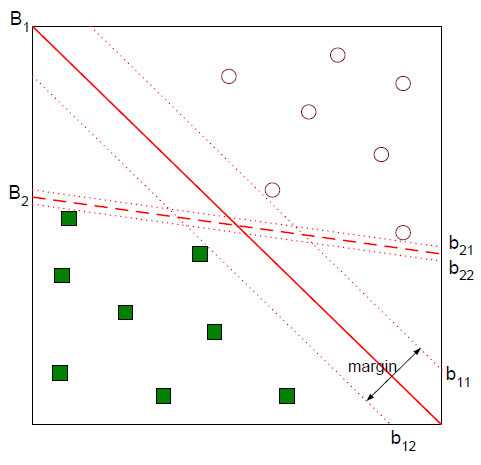

In [15]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X_tr, y_tr)

print(f"훈련 셋: {svr.score(X_tr, y_tr)}")
print(f"검증 셋: {svr.score(X_val, y_val)}")

훈련 셋: -0.051599039533311464
검증 셋: -0.048884763532281106
